توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:

%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
import copy
import math
from PIL import Image

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
#################################################################################
# function 1
def displacement(img, displacement_x, displacement_y):
    ## To Do
    height, width, channel = img.shape
    displacement_x %= width
    displacement_y %= height
    temp_img = copy.deepcopy(img)
    temp_img[:, displacement_x:width , :] = img[:, 0:width-displacement_x, :]
    temp_img[:, 0:displacement_x, :] = img[:,  width-displacement_x:width, :]
    output_img = copy.deepcopy(temp_img)
    output_img[displacement_y:height, : , :] = temp_img[0:height-displacement_y, :, :]
    output_img[0:displacement_y, :, :] = temp_img[height-displacement_y:height,  :, :]
    return output_img

#################################################################################
# function 2
def rotation(image, angle):
    ## angle: in degree
    ## To Do
    wr, hr = rotatedRectWithMaxArea(image.shape[1], image.shape[0],
                                    math.radians(angle))
    rotated = rotate_bound(image, angle)
    h, w, _ = rotated.shape
    y1 = h//2 - int(hr/2)
    y2 = y1 + int(hr)
    x1 = w//2 - int(wr/2)
    x2 = x1 + int(wr)
    return rotated[y1:y2, x1:x2]


def rotate_bound(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    return cv2.warpAffine(image, M, (nW, nH))

def rotatedRectWithMaxArea(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle (maximal area) within the rotated rectangle.
    """
    if w <= 0 or h <= 0:
        return 0,0

    width_is_longer = w >= h
    side_long, side_short = (w,h) if width_is_longer else (h,w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        #   the other two corners are on the mid-line parallel to the longer line
        x = 0.5*side_short
        wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a*cos_a - sin_a*sin_a
        wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

    return wr,hr

#################################################################################
# function 3
def scaling(img, scale_factor):
    ## To Do
    height, width, channel = img.shape
    new_height, new_width = int(scale_factor*height), int(scale_factor*width)
    output_img = cv2.resize(img, (new_width, new_height))
    return output_img


#################################################################################
# function 4
def Brightness(img, brightness_factor):  ## for augmentation
    ## To Do
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - brightness_factor
    v[v > lim] = 255
    v[v <= lim] += brightness_factor

    final_hsv = cv2.merge((h, s, v))
    output_img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return output_img


#################################################################################
# function 5
def bluring(img, blur_kernel_size):# for augmentation
    ## To Do
    output_img = cv2.GaussianBlur(img, (blur_kernel_size, blur_kernel_size), 0)
    return output_img
#################################################################################
# function 6
def gaussian_noise(img, mu, sigma):#for augmentation
    ## To Do
    row,col,ch= img.shape
    gauss = np.random.normal(mu,sigma,(row,col,ch))
    gauss = np.uint8(gauss.reshape(row,col,ch))
    output_img = cv2.add(img, gauss)
    return output_img.astype(np.uint8)



#################################################################################

In [4]:
print(os.getcwd())

/kaggle/working


In [5]:
os.chdir('ADEChallengeData2016/images/validation')

In [6]:
print(os.getcwd())

/kaggle/working/ADEChallengeData2016/images/validation


In [7]:
img = cv2.imread('ADE_val_00001838.jpg')

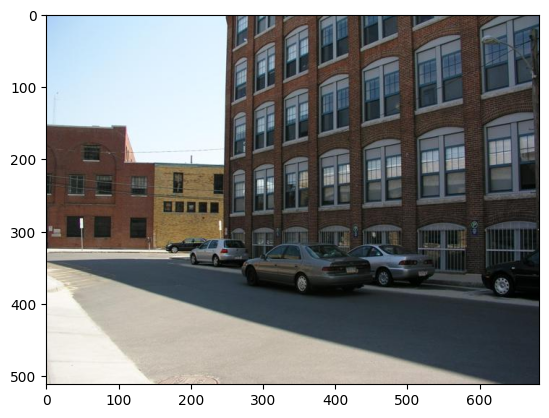

In [8]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

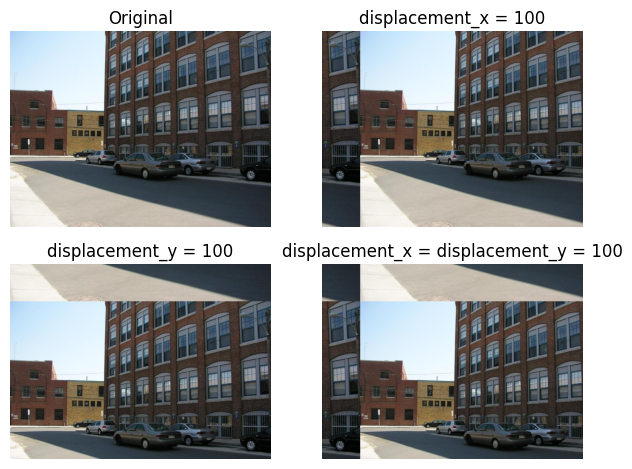

In [9]:
# show displacement results
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
output_img = displacement(img, 100, 0)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('displacement_x = 100')

plt.subplot(2, 2, 3)
output_img = displacement(img, 0, 100)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('displacement_y = 100')

plt.subplot(2, 2, 4)
output_img = displacement(img, 100, 100)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('displacement_x = displacement_y = 100')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


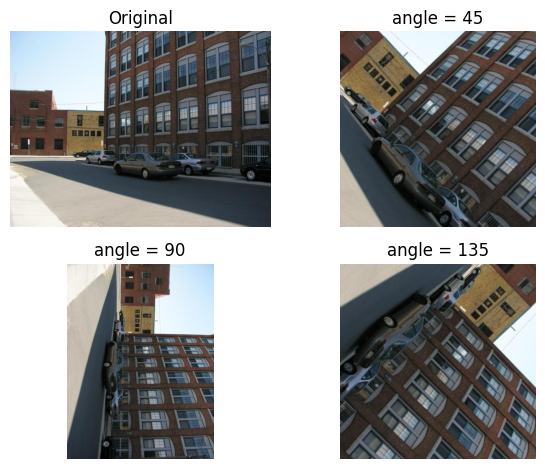

In [10]:
# show rotation results
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
output_img =rotation(img, 45)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('angle = 45')

plt.subplot(2, 2, 3)
output_img =rotation(img, 90)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('angle = 90')

plt.subplot(2, 2, 4)
output_img =rotation(img, 135)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('angle = 135')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

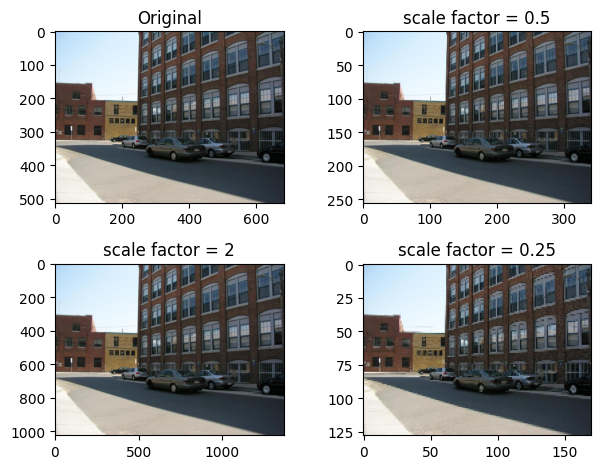

In [11]:
# show scaling results
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
output_img =scaling(img, 0.5)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.title('scale factor = 0.5')

plt.subplot(2, 2, 3)
output_img =scaling(img, 2)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.title('scale factor = 2')

plt.subplot(2, 2, 4)
output_img =scaling(img, 0.25)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
#plt.axis('off')
plt.title('scale factor = 0.25')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


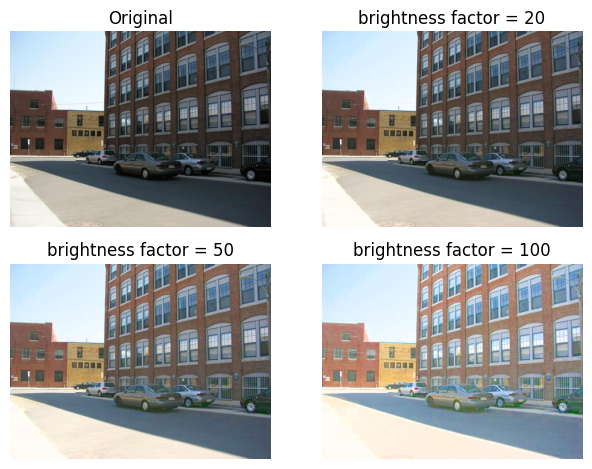

In [12]:
# show Brightness results
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
output_img =Brightness(img, 20)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('brightness factor = 20')

plt.subplot(2, 2, 3)
output_img =Brightness(img, 50)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('brightness factor = 50')

plt.subplot(2, 2, 4)
output_img =Brightness(img, 100)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('brightness factor = 100')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



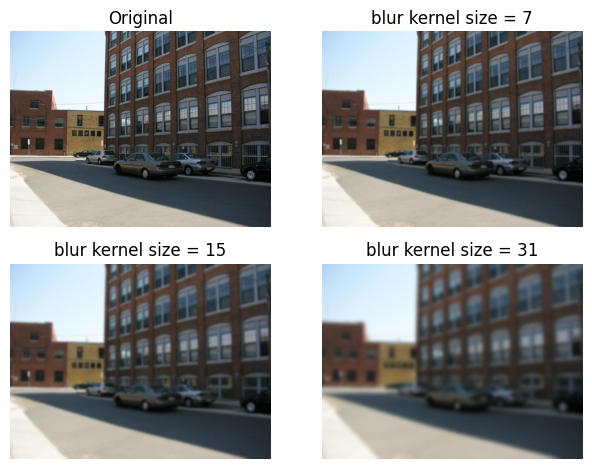

In [13]:
# show bluring results
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
output_img = bluring(img, 7)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('blur kernel size = 7')

plt.subplot(2, 2, 3)
output_img = bluring(img, 15)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('blur kernel size = 15')

plt.subplot(2, 2, 4)
output_img = bluring(img, 31)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('blur kernel size = 31')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()



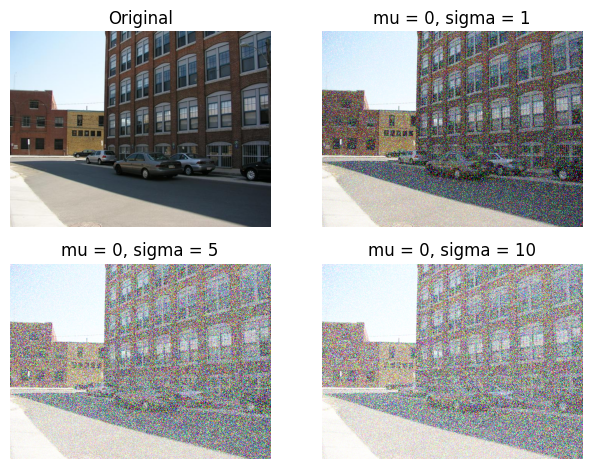

In [14]:
# show gaussian_noise results
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
output_img = gaussian_noise(img, 0, 1)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('mu = 0, sigma = 1')

plt.subplot(2, 2, 3)
output_img = gaussian_noise(img, 0, 5)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('mu = 0, sigma = 5')

plt.subplot(2, 2, 4)
output_img = gaussian_noise(img, 0, 10)
plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('mu = 0, sigma = 10')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()


In [15]:

class CustomDataset(Dataset):
    def __init__(self, root, transforms):
        ## To Do
        super(CustomDataset, self).__init__()
        self.images = [img for img in os.listdir(root) if img.endswith('.jpg')]
        self.transform = transforms
        self.root = root

    def __getitem__(self,idx):
        ## To Do
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root, self.images[idx])
        image = Image.open(img_name)
        image = image.convert('RGB')
        changed_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        label = np.zeros(3)
        num_of_changes = np.random.randint(0, 4)
        for i in range(num_of_changes):
            random_func = np.random.randint(1, 4)
            match random_func:
                case 1:
                    dis_x, dis_y = np.random.randint(10, 50), np.random.randint(10, 50)
                    changed_image = displacement(changed_image, dis_x, dis_y)
                    label[0] = 1
                case 2:
                    angle = np.random.randint(30, 90)
                    changed_image = rotation(changed_image, angle)
                    label[1] = 1
                case 3:
                    scaling_factor = np.random.uniform(0.5,2)
                    changed_image = scaling(changed_image, scaling_factor)
                    label[2] = 1
        changed_image = Image.fromarray(cv2.cvtColor(changed_image, cv2.COLOR_BGR2RGB))
        if self.transform:
            image = self.transform(image)
            changed_image = self.transform(changed_image)

        return image, changed_image, label

    def __len__(self):
        ## To Do
        return len(self.images)

In [16]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# For Google Colab
#dataset_train = CustomDataset(root='./ADEChallengeData2016/images/training',transforms=transform)## To Do
#dataset_test = CustomDataset(root='./release_test/testing',transforms=transform)## To Do
#dataset_val = CustomDataset(root='./ADEChallengeData2016/images/validation',transforms=transform)## To Do

# For Kaggle
os.chdir(os.path.expanduser('~'))
dataset_train = CustomDataset(root='/kaggle/working/ADEChallengeData2016/images/training',transforms=transform)## To Do
dataset_test = CustomDataset(root='/kaggle/working/release_test/testing',transforms=transform)## To Do
dataset_val = CustomDataset(root='/kaggle/working/ADEChallengeData2016/images/validation',transforms=transform)## To Do

train_loader = DataLoader(dataset_train,batch_size=32, shuffle=True)## To Do
test_loader= DataLoader(dataset_test,batch_size=32, shuffle=False)## To Do
val_loader = DataLoader(dataset_val,batch_size=32, shuffle=False)## To Do


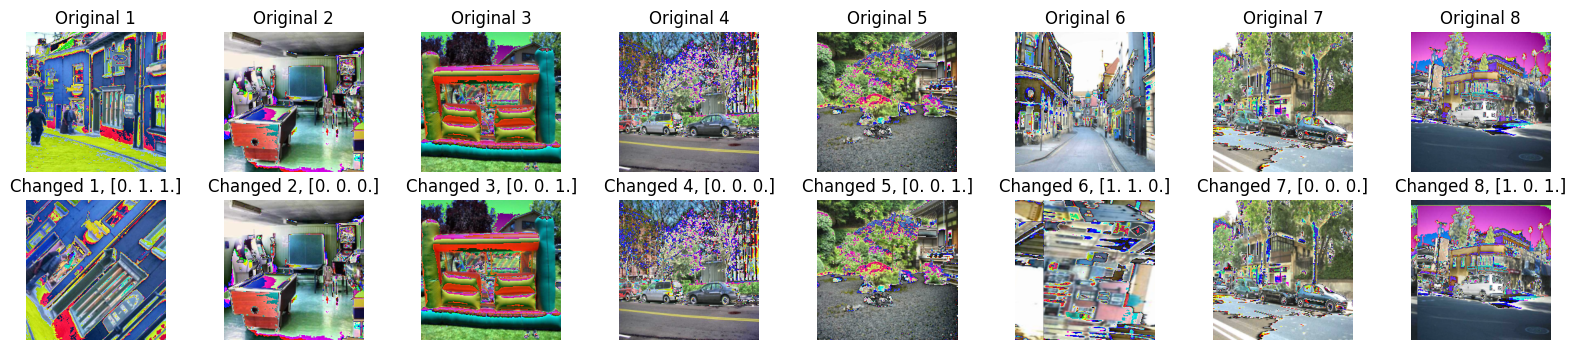

In [17]:
## To Do  : show 8 images from train_loader & 8 images from test_loader

# show 8 images from train_loader
data_iter = iter(train_loader)
images, changed_images, label = next(data_iter)

# Display the images
fig, axes = plt.subplots(2, 8, figsize=(20, 4))
axes = axes.flatten()

for i in range(8):
    img = transforms.ToPILImage()(images[i])
    changed_img = transforms.ToPILImage()(changed_images[i])

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Original {i + 1}')

    axes[i + 8].imshow(changed_img)
    axes[i + 8].axis('off')
    axes[i + 8].set_title(f'Changed {i + 1}, {label[i].numpy()}')

plt.show()


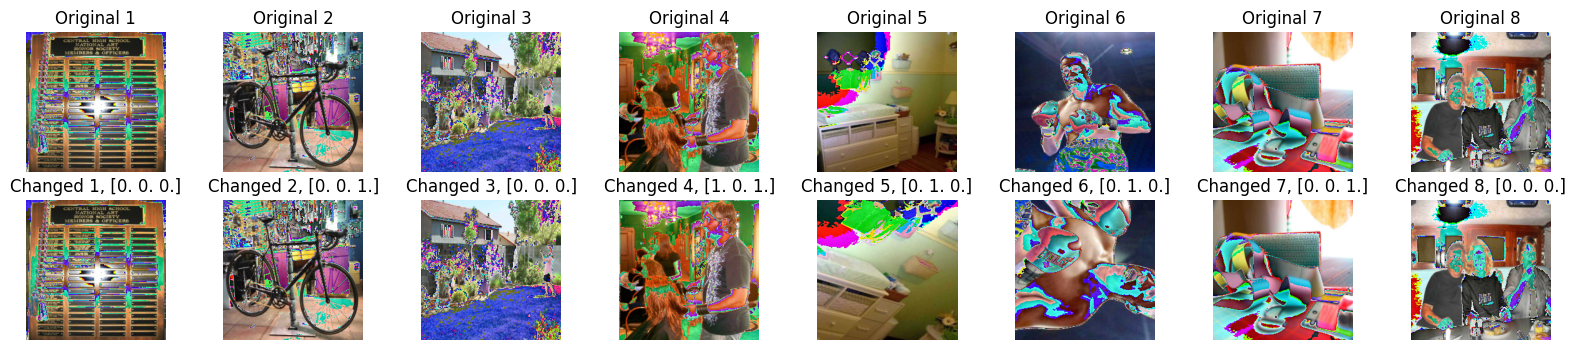

In [18]:
# show 8 images from test_loader
# show 8 images from train_loader
data_iter = iter(test_loader)
images, changed_images, label = next(data_iter)

# Display the images
fig, axes = plt.subplots(2, 8, figsize=(20, 4))
axes = axes.flatten()

for i in range(8):
    img = transforms.ToPILImage()(images[i])
    changed_img = transforms.ToPILImage()(changed_images[i])

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Original {i + 1}')

    axes[i + 8].imshow(changed_img)
    axes[i + 8].axis('off')
    axes[i + 8].set_title(f'Changed {i + 1}, {label[i].numpy()}')

plt.show()

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

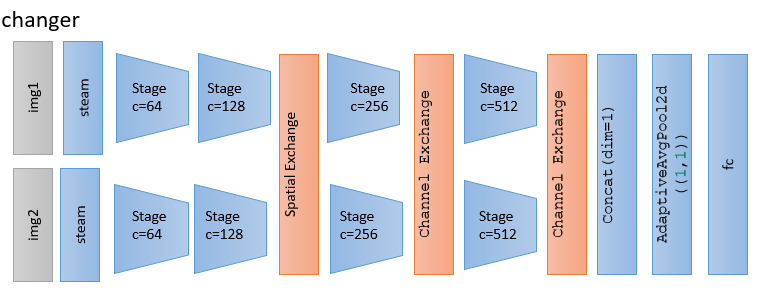

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


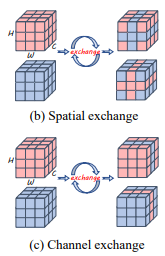

In [19]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

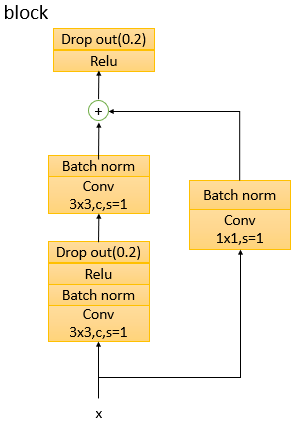

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





#### answer:

1. In the block diagram above, we have some $1\times1$ convolutions or "bottlenecks" that their size is $1\times1\times C$ that $C$ is equal to the number of input feature-map channels (for example, for an RGB input image $C=3$). Note that the number of output feature-map channels is equal to the number of bottleneck filters. For the bottleneck filters, padding size is equal to $p=0$ and for $3\times3$ convolutions, the padding size is equal to $p=1$ (same mode); because we have a skip-connection in the block diagram, so the shape of input and output feature-maps should be the same.


2. We use $1\times1$ convolutions or "bottlenecks" to reduce the number of input feature-map channels and compound data channels.
In a CNN, bottleneck layers are added to reduce the number of feature maps (aka channels) in the network, which, otherwise, tend to increase in each layer. This is achieved by using $1\times1$ convolutions with fewer output channels than input channels.

In [20]:
##To Do
class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(block,self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout2d(p=0.2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection 
        self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self,x):
        residual = x

        # Forward pass through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Forward pass through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)

        # Add the shortcut connection
        out += self.shortcut(residual)
        out = self.relu1(out)
        out = self.dropout1(out)

        return out

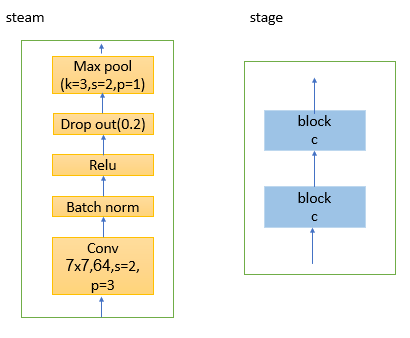

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [21]:
#To Do
class changer(nn.Module):
    def __init__(self,block,SpatialExchange,ChannelExchange):
        super(changer,self).__init__()

        self.steam=nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        #self.block = block()
        self.stage1=nn.Sequential( 
            block(64, 64),
            block(64, 64)
        )
        self.stage2=nn.Sequential( 
            block(64, 128),
            block(128, 128)
        )
        self.stage3=nn.Sequential( 
            block(128, 256),
            block(256, 256)
        )
        self.stage4=nn.Sequential( 
            block(256, 512),
            block(512, 512)
        )

        self.SpatialExchange = SpatialExchange()
        self.ChannelExchange = ChannelExchange()
        self.FC = nn.Sequential( 
            nn.Flatten(),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 3),
            nn.Sigmoid()
        )



    def _make_stage(self,stage_level):
        layers=[]
        match stage_level:
            case 1:
                layers.append(self.steam)
                layers.append(self.stage1)
                layers.append(self.stage2)
            case 2:
                layers.append(self.stage3)
            case 3:
                layers.append(self.stage4)
        return nn.Sequential(*layers)




    def forward(self,x1,x2):
        layer1 = self._make_stage(1)
        out1, out2 = layer1(x1), layer1(x2)
        out1, out2 = self.SpatialExchange.forward(out1, out2)
        layer2 = self._make_stage(2)
        out1, out2 = layer2(out1), layer2(out2)
        out1, out2 = self.ChannelExchange.forward(out1, out2)
        layer3 = self._make_stage(3)
        out1, out2 = layer3(out1), layer3(out2)
        out1, out2 = self.ChannelExchange.forward(out1, out2)
        out = torch.cat((out1, out2), dim=1)
        adaptive_avgpool = nn.AdaptiveAvgPool2d((1,1))
        out = adaptive_avgpool(out)
        out = self.FC(out)
        return out

In [22]:
## To Do
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model=changer(block,SpatialExchange,ChannelExchange).to(device)
criterion = nn.CrossEntropyLoss().to(device)## loss
optimizer= optim.Adam(model.parameters(),lr=0.01) ## optimizer

##Train & validation


In [23]:
from sklearn.metrics import f1_score
epochs= 4
Loss_train=[]
Loss_val=[]
train_acc = []
val_acc = []
f1_train, f1_val = [] , []
PATH = "checkpoint.pth"
for epoch in range(1, epochs + 1):
    #model.trian() 
    total_loss_train = 0.0
    correct_train = 0
    total_train = 0
    total_f1_train = []
    for x1, x2, label in train_loader:
        x1, x2, label = x1.to(device), x2.to(device), label.to(device)     
        out = model(x1, x2)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
         
        with torch.no_grad(): 
            total_loss_train += loss.item()
            predictions = (out > 0.5).float() # Assuming a threshold of 0.5
            correct_train += (predictions == label).sum().item()
            total_train += label.size(0)
            total_f1_train.append(f1_score(predictions.cpu().numpy(), label.cpu().numpy(), average='micro'))
            
    average_loss_train = total_loss_train / len(train_loader)
    accuracy_train = correct_train / total_train    
    average_f1_train = np.mean(total_f1_train) 

 
    #model.eval() 
    total_loss_val = 0.0
    correct_val = 0
    total_val = 0
    total_f1_val = []
    with torch.no_grad():
        for x1_val, x2_val, label_val in val_loader:
            x1_val, x2_val, label_val = x1_val.to(device), x2_val.to(device), label_val.to(device)
            out_val = model(x1_val, x2_val)
            loss_val = criterion(out_val, label_val)
            total_loss_val += loss_val.item()
            predictions = (out_val > 0.5).float()
            correct_val += (predictions == label_val).sum().item()
            total_val += label_val.size(0)
            total_f1_val.append(f1_score(predictions.cpu().numpy(), label_val.cpu().numpy(), average='micro'))
            
    average_loss_val = total_loss_val / len(val_loader)
    accuracy_val = correct_val / total_val
    average_f1_val = np.mean(total_f1_val) 
 
    print(f'epoch: {epoch}, loss_TRAIN ={average_loss_train:.5f},acc_train={accuracy_train:.3%},f1score_train={average_f1_train:.3%},\t loss_val= {average_loss_val:.5f}, acc_val={accuracy_val:.3%},f1score_val={average_f1_val:.3%}')
    checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }
    torch.save(checkpoint, PATH)
    Loss_train.append(average_loss_train)
    train_acc.append(accuracy_train)
    Loss_val.append(average_loss_val)
    val_acc.append(accuracy_val)
    f1_train.append(average_f1_train)
    f1_val.append(average_f1_val)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


epoch: 1, loss_TRAIN =1.30589,acc_train=181.019%,f1score_train=0.205%,	 loss_val= 1.26319, acc_val=185.250%,f1score_val=0.000%
epoch: 2, loss_TRAIN =1.30141,acc_train=181.524%,f1score_train=0.000%,	 loss_val= 1.33076, acc_val=178.800%,f1score_val=0.000%
epoch: 3, loss_TRAIN =1.31708,acc_train=180.104%,f1score_train=0.000%,	 loss_val= 1.29806, acc_val=181.800%,f1score_val=0.000%
epoch: 4, loss_TRAIN =1.31507,acc_train=180.287%,f1score_train=0.000%,	 loss_val= 1.33239, acc_val=179.100%,f1score_val=0.000%


Since we have a multi-label classification, the accuracy score is not the best parameter, so I use f1_score which is meaningful for the multi-label classification tasks.

#Test


In [24]:

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
correct_zero_change, correct_one_change, correct_two_change, correct_three_change = 0,0,0,0
num_zero_change, num_one_change, num_two_change, num_three_change = 0,0,0,0

## To Do test
total_loss_test = 0.0
correct_test = 0
total_test = 0
f1_test = []
#model.eval() 
with torch.no_grad():
    for x1_test, x2_test, label_test in test_loader:
        x1_test, x2_test, label_test = x1_test.to(device), x2_test.to(device), label_test.to(device)
        out_test = model(x1_test, x2_test)
        loss = criterion(out_test, label_test)
        total_loss_test += loss.item()
        predictions = (out_test > 0.5).float()
        correct_test += (predictions == label_test).sum().item()
        total_test += label_test.size(0)
        f1_test.append(f1_score(predictions.cpu().numpy(), label_test.cpu().numpy(), average='micro'))
        sum_changes = torch.sum(label_test, dim=1)
        for i in range(sum_changes.size(0)):
            match sum_changes[i]:
                case 0:
                    num_zero_change += 1
                    if torch.equal(predictions[i, :], label_test[i, :]):
                        correct_zero_change += 1
                case 1:
                    num_one_change += 1
                    if torch.equal(predictions[i, :], label_test[i, :]):
                        correct_one_change += 1
                case 2:
                    num_two_change += 1
                    if torch.equal(predictions[i, :], label_test[i, :]):
                        correct_two_change += 1
                case 3:
                    num_three_change += 1
                    if torch.equal(predictions[i, :], label_test[i, :]):
                        correct_three_change += 1
        
average_loss_test = total_loss_test / len(test_loader)
accuracy_test = correct_test / total_test
f1_test_avg = np.mean(f1_test)

print(f' loss_test= {average_loss_test:.5f}, acc_test={accuracy_test:.3%}, f1score_test={f1_test_avg:.3%}')

 loss_test= 1.28259, acc_test=183.294%, f1score_test=0.000%


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [25]:
acc_zero_change, acc_one_change = correct_zero_change/num_zero_change, correct_one_change/num_one_change
acc_two_change, acc_three_change = correct_two_change/num_two_change, correct_three_change/num_three_change
print(f'acc_test with 0 change = {acc_zero_change:.3%} , acc_test with 1 change = {acc_one_change:.3%}')
print(f'acc_test with 2 changes = {acc_two_change:.3%} , acc_test with 3 change = {acc_three_change:.3%}')

acc_test with 0 change = 100.000% , acc_test with 1 change = 0.000%
acc_test with 2 changes = 0.000% , acc_test with 3 change = 0.000%


In [26]:
print(num_zero_change, num_one_change, num_two_change, num_three_change)
print(correct_zero_change, correct_one_change, correct_two_change, correct_three_change)

862 1242 1074 174
862 0 0 0


As you can see from the results above, the accuracy score for classes with three changes is the best!